# Layout:

1.	Import Packages/Libraries
2.	Read Dataset From Scrape
3.	Clean Data and add Dummy Variables
    + Remove Duplicate Values
    + Set Column Value Types from Object to Regression-Friendly Values
    + Turn Categorical Data into 0/1 Variables
    + Drop Movies/Anime
4.	Split Data into Train and Test Sets
    + Split Dependent and Independent Variables
    + Make Train/Test Datasets and Turn Training into a DataFrame
    + Remove Outliers from Training Set
5.	Exploratory Data Analysis (EDA) on Train Data
    + Pairplots of All Variables
    + Correlations
6.	Base OLS Model on Original Train Data
    + OLS Fit and Summary
    + K-Fold Validation
    + Plot Predictions vs Actual
    + Diagnostic Plots on Base Model
        + Residuals vs Fitted
        + Normal Q-Q
        + Scale-Location
        + Residuals vs Leverage
8.	Rescale Data As Needed
    + Log and Plot Dependent
    + Attempt Boxcox Transformations and Plot- Ignore Results
9.	EDA on Scaled Data
10.	Regression on Logged Values
    + Drop Multicollinear Elements
    + Run OLS Fit and Summary
    + Run K-Fold CV
    + Plot Predictions vs Actual
	+ Diagnostic Plots on Updated Train Data
        + Residuals vs Fitted
        + Normal Q-Q
        + Scale-Location
        + Residuals vs Leverage
12.	Polynomial Features
13. EDA with Polynomial Data
14.	Regression with Polynomial Features
    + Run OLS Fit and Summary
    + Run K-Fold CV
    + Plot Predictions vs Actual
	+ Diagnostic Plots on Updated Train Data
        + Residuals vs Fitted
        + Normal Q-Q
        + Scale-Location
        + Residuals vs Leverage
15.	Compare Linear and More Complicated Models’ R2 Scores
    + Make Function to Compare with Previously Made K-Folds
    + Run Comparison on Train Data
    + Run on Modified Data
16.	Check Inputs of Best Model on Entire Train Data to Maximize R2 and Minimize Overfitting
17.	Run “Best” Model on Entire Testing Data (Holdout Set)
18.	Plot Final Results

# 1. Mass Importation

In [1]:
import pandas as pd
import numpy as np
import dateutil.parser
from datetime import date
import re

from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import os

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from scipy import stats
from sklearn import linear_model,ensemble, tree, model_selection, datasets
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV

import diagnostic_plots

import pickle
import time

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 2. Read Dataset from Scrape

In [50]:
df=pd.read_csv('steam3.csv')
del(df['Unnamed: 0'])
df.set_index('title', inplace=True)
df.head()

,link,system,systems,reviews,release_date,discount,price
title,,,,,,,
Warframe,https://store.steampowered.com/app/230410/Warf...,1,['win'],192592,1940,0,0.00
Clicker Heroes 2,https://store.steampowered.com/app/629910/Clic...,2,"['win', 'mac']",183,1,0,29.99
Tom Clancy's Rainbow Six® Siege,https://store.steampowered.com/app/359550/Tom_...,1,['win'],170518,959,0,14.99
Counter-Strike: Global Offensive,https://store.steampowered.com/app/730/Counter...,3,"['win', 'mac', 'linux']",2628652,2156,0,14.99
Grand Theft Auto V,https://store.steampowered.com/app/271590/Gran...,1,['win'],343780,1191,34,29.99


# 3. Clean Data and Add Dummy Variables

## Remove Duplicates

In [3]:
no_dup_df = df[~df.index.duplicated(keep='first')]

## Set Column Value Types

In [4]:
no_dup_df['system'] = no_dup_df.system.astype(int)
no_dup_df['reviews'] = no_dup_df.reviews.astype(int)
no_dup_df['release_date'] = no_dup_df.release_date.astype(int)
no_dup_df['discount'] = no_dup_df.discount.astype(int)
no_dup_df['price'] = no_dup_df.price.astype(float)
no_dup_df['systems'] = no_dup_df.systems.astype(list)

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

## Windows, Mac, Linux -> Dummy Variables

In [5]:
windows=[1 if 'win' in item else 0 for item in no_dup_df.systems]
mac=[1 if 'mac' in item else 0 for item in no_dup_df.systems]
linux=[1 if 'linux' in item else 0 for item in no_dup_df.systems]

In [6]:
no_dup_df['windows']=windows
no_dup_df['mac']=mac
no_dup_df['linux']=linux

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [7]:
no_dup_df['windows'] = no_dup_df.windows.astype(int)
no_dup_df['mac'] = no_dup_df.mac.astype(int)
no_dup_df['linux'] = no_dup_df.linux.astype(int)
#no_dup_df.info()

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

## Drop Streaming Videos

In [8]:
movies=[]
for i in range(len(no_dup_df['systems'])):
    element=(no_dup_df['systems'][i])
    if 'win' not in element and 'mac' not in element and 'linux' not in element:
        movies.append(1)
    else:
        movies.append(0)
no_dup_df['movies']=movies
no_dup_df = no_dup_df[no_dup_df.movies != 1]
del(no_dup_df['movies'])

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# 4. Split Data into Train/Test

## Split Dependent and Independent Variables From Original Dataset

In [9]:
y = no_dup_df['reviews']
X = no_dup_df.drop(['reviews','link','systems'], axis = 1)

## Make Train/Test Sets and Put in DataFrame

In [10]:
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.3)
tdf=X_t.join(y_t)

## Remove Outliers from Training Set

In [11]:
traindf=tdf[tdf.reviews < 100000]
y_train = traindf['reviews']
X_train = traindf.drop(['reviews'], axis = 1)

# 5. EDA on Train Data

## Pairplot

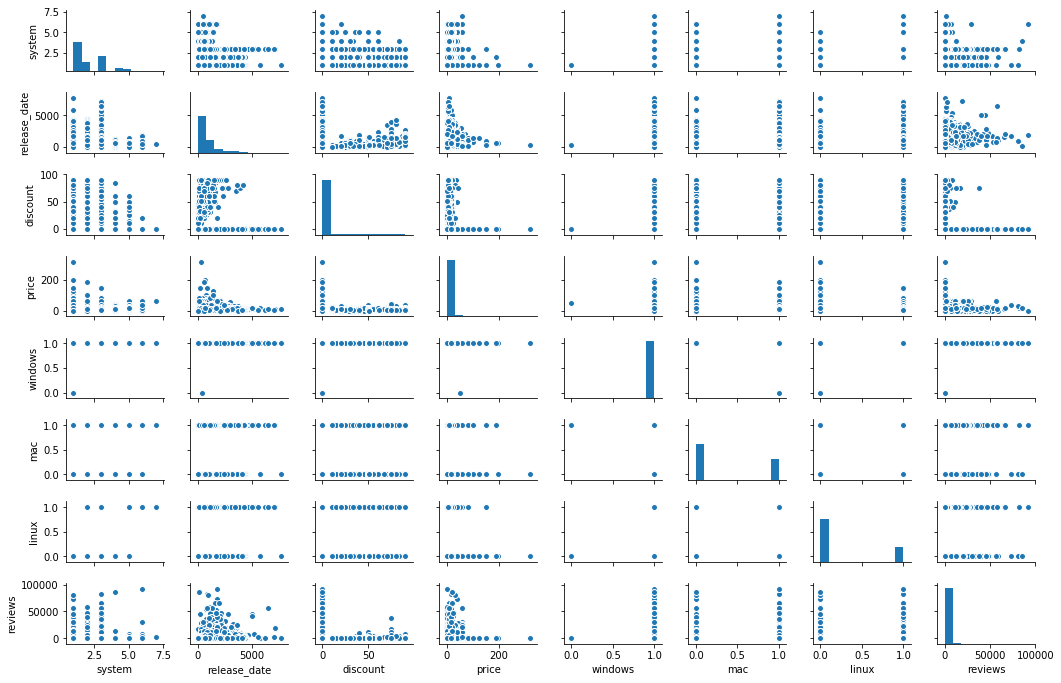

In [12]:
sns.pairplot(traindf, size = 1.2, aspect=1.5)

## Correlation Matrix

In [13]:
traindf.corr()
#sns.heatmap(no_dup_df.corr(), cmap="seismic")

,system,release_date,discount,price,windows,mac,linux,reviews
system,1.000000,-0.083500,-0.030351,0.039990,0.011489,0.504686,0.541869,0.032750
release_date,-0.083500,1.000000,-0.027238,0.048703,0.006952,0.065634,0.038983,0.198400
discount,-0.030351,-0.027238,1.000000,-0.042228,0.003126,0.002916,-0.000363,-0.015952
price,0.039990,0.048703,-0.042228,1.000000,-0.047147,0.011130,0.006653,0.155146
windows,0.011489,0.006952,0.003126,-0.047147,1.000000,-0.017525,0.008030,0.003279
mac,0.504686,0.065634,0.002916,0.011130,-0.017525,1.000000,0.649787,0.083283
linux,0.541869,0.038983,-0.000363,0.006653,0.008030,0.649787,1.000000,0.081824
reviews,0.032750,0.198400,-0.015952,0.155146,0.003279,0.083283,0.081824,1.000000


# 6. Base Model

## OLS Fit and Summary

In [14]:
model = sm.OLS(y_train, sm.add_constant(X_train))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                reviews   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     55.56
Date:                Thu, 19 Jul 2018   Prob (F-statistic):           3.76e-77
Time:                        18:00:06   Log-Likelihood:                -53901.
No. Observations:                5432   AIC:                         1.078e+05
Df Residuals:                    5424   BIC:                         1.079e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3971.2814   4949.352     -0.802      0.422   -1.37e+04    5731.434
system         -23.4143     74.556     -0.314      0.753    -169.574     122.745
release_date     1.0703      0.077     13.988      0.000       0.920       1.220
discount        -1.9266      5.056     -0.381      0.703     -11.839       7.985
price           63.8936      5.776     11.063      0.000      52.571      75.216
windows       3467.0273   4947.197      0.701      0.483   -6231.466    1.32e+04
mac            413.2142    188.333      2.194      0.028      44.006     782.423
linux          592.5439    212.973      2.782      0.005     175.031    1010.057
==============================================================================
Omnibus:                     7937.440   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2696582.607
Skew:                           8.875   Prob(JB):                         0.00
Kurtosis:                     110.699   Cond. No.                     1.26e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## K-Fold Validation; Return Average Score Across Folds

### 10-fold Cross Validation Split

In [15]:
kf=KFold(n=len(X_train), n_folds=10, shuffle=True, random_state=20)

### Calculate Avg Score Across Folds

In [16]:
def score(kf,X,y):
    all_scores_lr_train = []
    all_scores_lr_test = []
    for train, test in kf:
        Xt_train = X.iloc[train]
        yt_train=y.iloc[train]
        X_val = X.iloc[test]
        y_val = y.iloc[test]

        lr=LinearRegression()
        lr.fit(Xt_train, yt_train)
        all_scores_lr_train.append(lr.score(Xt_train,yt_train))
        all_scores_lr_test.append(lr.score(X_val,y_val))

    return ('train score mean: ' + str(np.mean(all_scores_lr_train)), 'test score mean: ' + str(np.mean(all_scores_lr_test)))

score(kf,X_train,y_train)

#model does worse than guessing the mean value of y at x
# r20= figure out what mean value of y- only gives average value as 0

('train score mean: 0.06716167290798572',
 'test score mean: 0.06376577282400998')

## Plot Predicted vs Actual

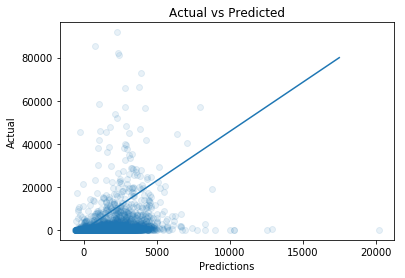

In [17]:
predict = fit.predict(sm.add_constant(X_train))
plt.scatter(predict,y_train,alpha=.1)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.plot(np.linspace(0,17500,1000),np.linspace(0,80000,1000));
plt.title('Actual vs Predicted');

## Diagnostic Plots on Base Model

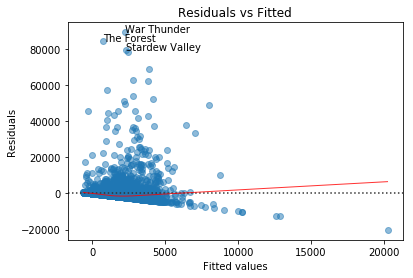

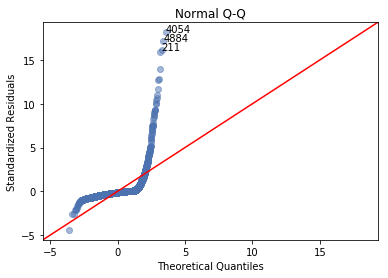

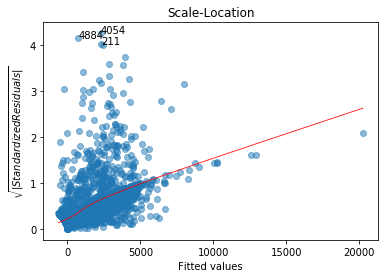

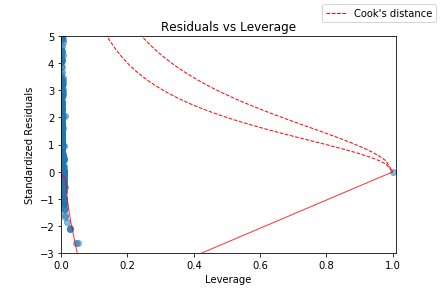

In [18]:
y_traindf=pd.DataFrame(y_train)
X_traindf=pd.DataFrame(X_train)
diagnostic_plots.diagnostic_plots(X_traindf, y_traindf, fit)

#residuals are not normally distributed

# 7. Rescale/Normalize Data

## Log Dependent Data

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(array([1398.,    0., 1031.,  850.,  723.,  555.,  438.,  266.,  134.,
          37.]),
 array([ 0.        ,  1.14273894,  2.28547787,  3.42821681,  4.57095575,
         5.71369468,  6.85643362,  7.99917255,  9.14191149, 10.28465043,
        11.42738936]),
 <a list of 10 Patch objects>)

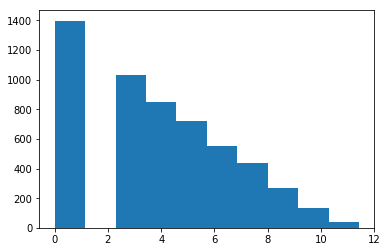

In [19]:
traindf['log_reviews'] = np.log(traindf.reviews + 1)
plt.hist(traindf['log_reviews'])

## Boxcox- makes no difference, stick to log

In [20]:
yt, _ = stats.boxcox(traindf['reviews']+1)

(array([1398.,    0.,  720.,  859.,  715.,  662.,  507.,  328.,  191.,
          52.]),
 array([0.        , 0.97390656, 1.94781312, 2.92171968, 3.89562624,
        4.8695328 , 5.84343936, 6.81734593, 7.79125249, 8.76515905,
        9.73906561]),
 <a list of 10 Patch objects>)

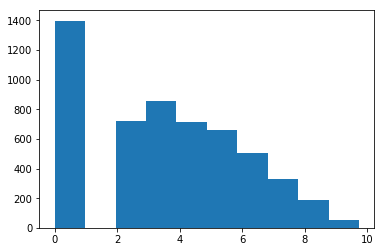

In [21]:
plt.hist(yt)

# 8. EDA on Scaled Data; Log Reviews as Dependent

## Pairplot

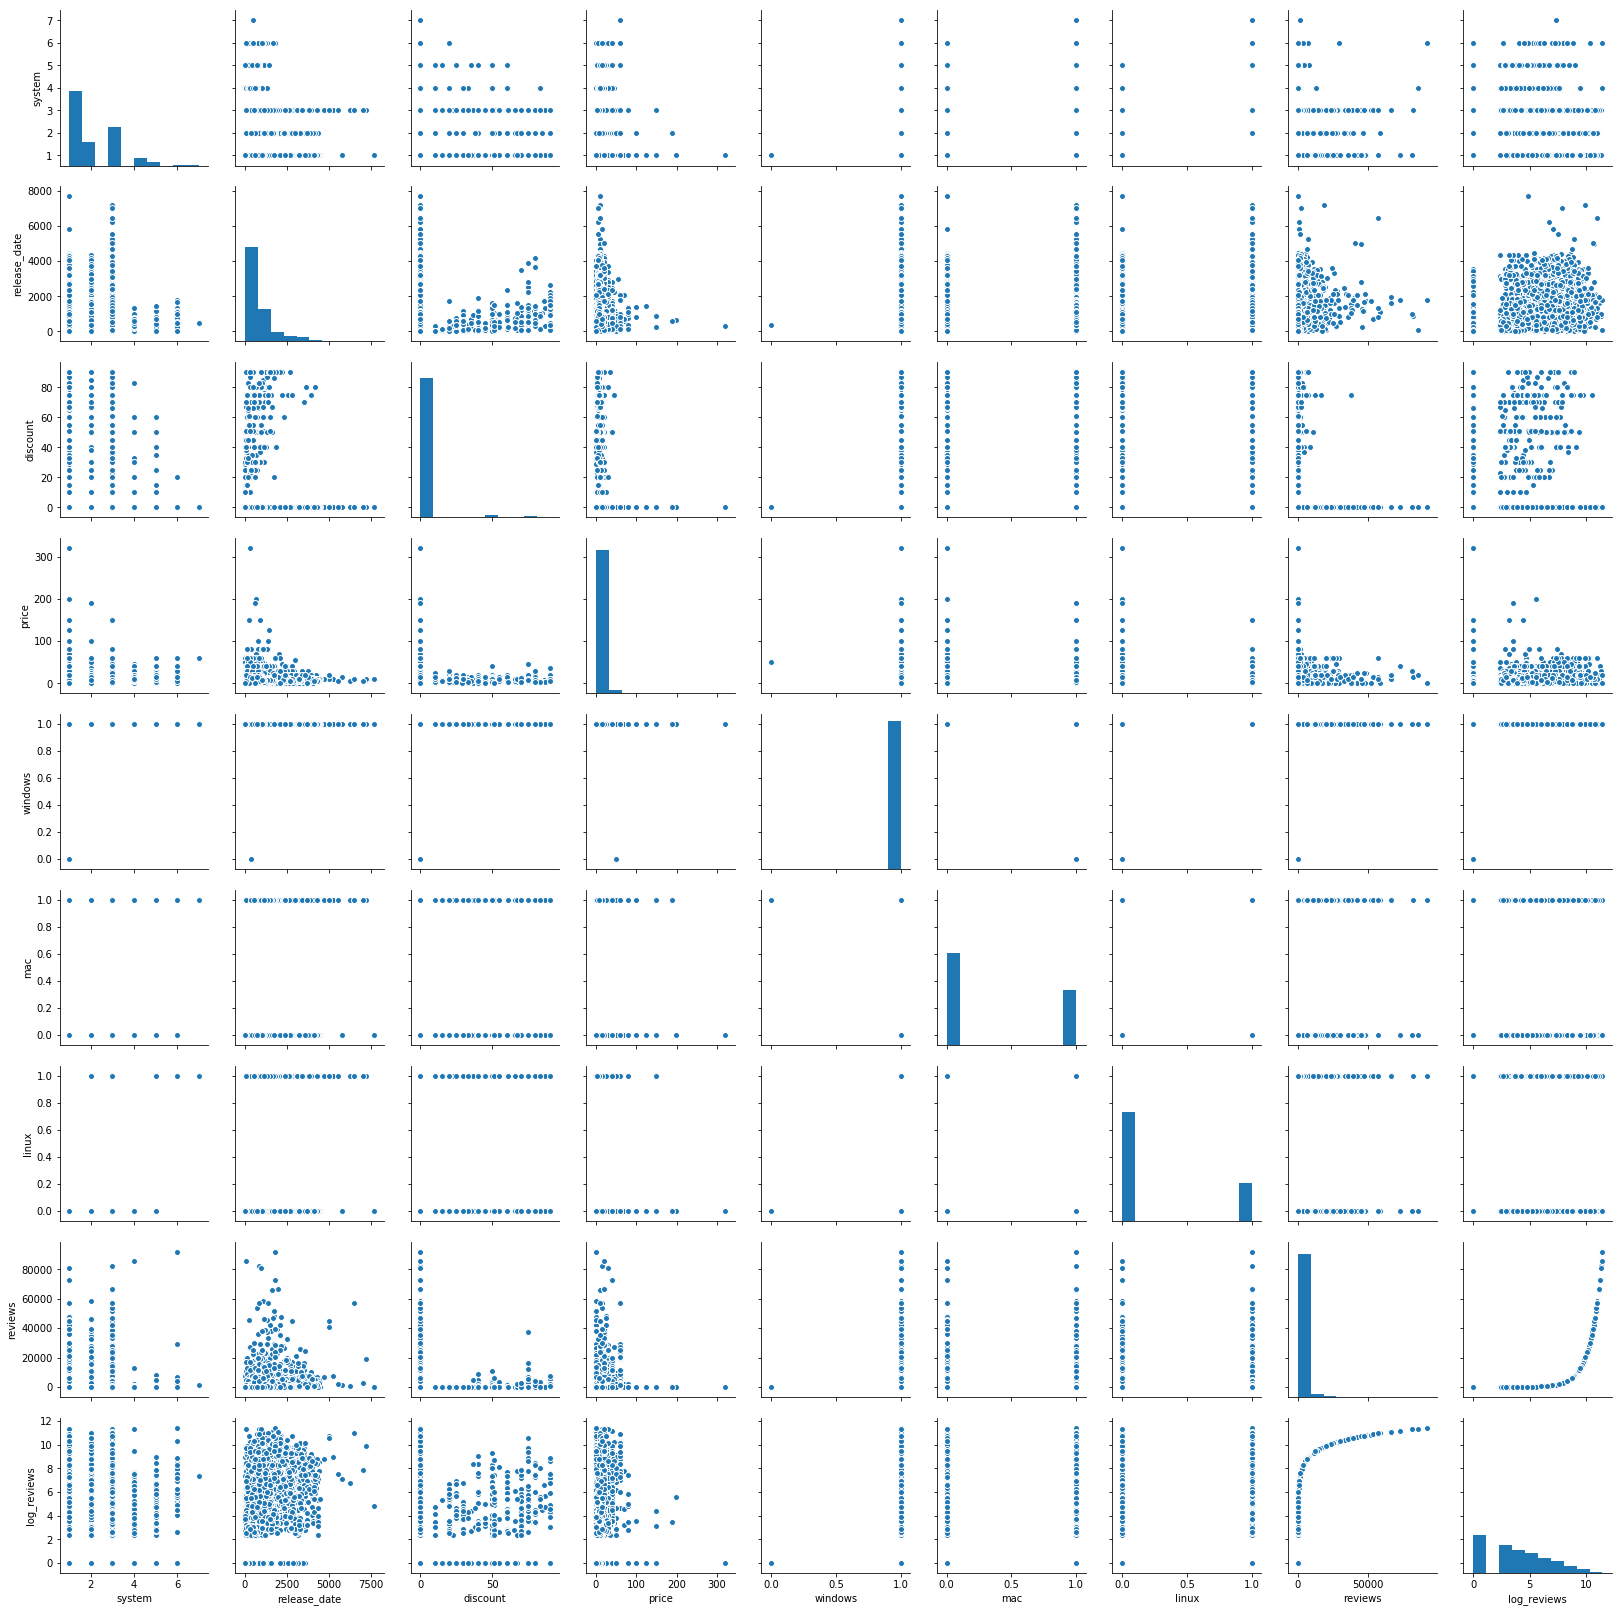

In [22]:
sns.pairplot(traindf)

## Correlation Matrix

In [23]:
traindf.corr()
#windows doesnt seem correlated- because windows is almost columns

,system,release_date,discount,price,windows,mac,linux,reviews,log_reviews
system,1.000000,-0.083500,-0.030351,0.039990,0.011489,0.504686,0.541869,0.032750,0.075025
release_date,-0.083500,1.000000,-0.027238,0.048703,0.006952,0.065634,0.038983,0.198400,0.411966
discount,-0.030351,-0.027238,1.000000,-0.042228,0.003126,0.002916,-0.000363,-0.015952,0.018997
price,0.039990,0.048703,-0.042228,1.000000,-0.047147,0.011130,0.006653,0.155146,0.256125
windows,0.011489,0.006952,0.003126,-0.047147,1.000000,-0.017525,0.008030,0.003279,0.018140
mac,0.504686,0.065634,0.002916,0.011130,-0.017525,1.000000,0.649787,0.083283,0.195373
linux,0.541869,0.038983,-0.000363,0.006653,0.008030,0.649787,1.000000,0.081824,0.182331
reviews,0.032750,0.198400,-0.015952,0.155146,0.003279,0.083283,0.081824,1.000000,0.461558
log_reviews,0.075025,0.411966,0.018997,0.256125,0.018140,0.195373,0.182331,0.461558,1.000000


# 9. Regression on Log Values

## Drop Highly Multicollinear Elements
+ Those with no reviews
+ That don't run on windows

In [24]:
mask = (traindf.reviews > 0)

## OLS Model

In [25]:
traindf2 = traindf[mask]
y2_train = traindf2['log_reviews']
X2_train = traindf2.drop(['log_reviews','reviews', 'system', 'windows'], axis = 1)

model2 = sm.OLS(y2_train, sm.add_constant(X2_train))
fit2 = model2.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_reviews   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     226.5
Date:                Thu, 19 Jul 2018   Prob (F-statistic):          1.41e-213
Time:                        18:00:29   Log-Likelihood:                -8106.4
No. Observations:                4034   AIC:                         1.622e+04
Df Residuals:                    4028   BIC:                         1.626e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.6492      0.055     66.858      0.000       3.542       3.756
release_date     0.0008   3.04e-05     25.715      0.000       0.001       0.001
discount         0.0036      0.002      1.777      0.076      -0.000       0.008
price            0.0474      0.002     19.095      0.000       0.043       0.052
mac              0.3308      0.077      4.287      0.000       0.179       0.482
linux            0.3074      0.083      3.695      0.000       0.144       0.471
==============================================================================
Omnibus:                      146.422   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.771
Skew:                           0.446   Prob(JB):                     3.71e-37
Kurtosis:                       3.449   Cond. No.                     4.88e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## K-Fold CV

### 10-fold Cross Validation Split

In [26]:
kf2=KFold(n=len(X2_train), n_folds=10, shuffle=True, random_state=20)

### Calculate Avg Score Across Folds

In [27]:
score(kf2,X2_train,y2_train)

('train score mean: 0.2196248002755457', 'test score mean: 0.2149937273186416')

## Plot Predicted vs Actual

Text(0.5,1,'Actual vs Predicted')

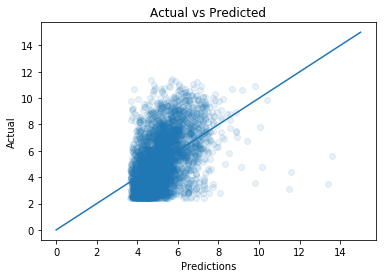

In [28]:
predict2 = fit2.predict(sm.add_constant(X2_train))
plt.scatter(predict2,y2_train,alpha=.1)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.plot(np.linspace(0,15,100),np.linspace(0,15,100))
plt.title('Actual vs Predicted')

## Diagnostic Plots

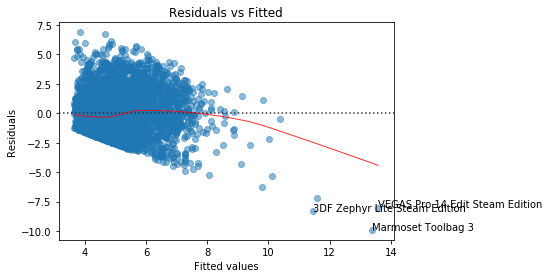

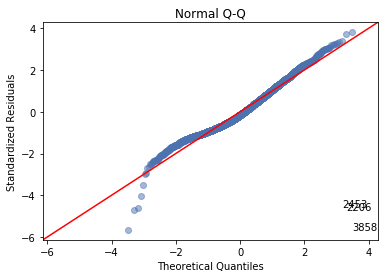

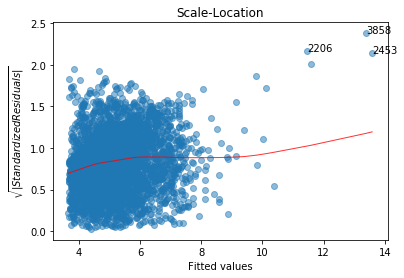

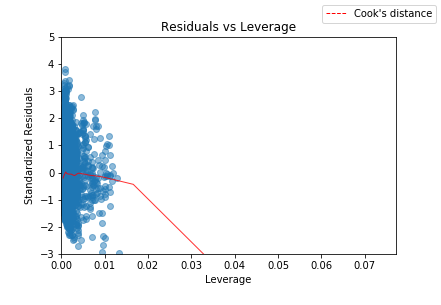

In [29]:
y_traindf2=pd.DataFrame(y2_train)
X_traindf2=pd.DataFrame(X2_train)
diagnostic_plots.diagnostic_plots(X_traindf2, y_traindf2, fit2)

# 10. Add Polynomial Features

In [30]:
X2_poly = X2_train[['release_date', 'price']]
poly = PolynomialFeatures(2)
X2_polynomialfeatures = poly.fit_transform(X2_poly)

In [31]:
X2_polynomialfeaturesdf = pd.DataFrame(X2_polynomialfeatures, columns=[list(poly.get_feature_names())])
X2_polynomialfeaturesdf.index=X2_train.index
X2_polynomialfeaturesdf.head()

,1,x0,x1,x0^2,x0 x1,x1^2
title,,,,,,
Death Squared,1.0,491.0,14.99,241081.0,7360.09,224.7001
Crimson Memories,1.0,288.0,1.99,82944.0,573.12,3.9601
Animal Lover,1.0,518.0,9.99,268324.0,5174.82,99.8001
SPORE™,1.0,3497.0,19.99,12229009.0,69905.03,399.6001
Nex Machina,1.0,392.0,19.99,153664.0,7836.08,399.6001


In [32]:
X2_polynomialfeatures = pd.DataFrame(X2_polynomialfeatures, columns=[['constant','release_date','price','release_date^2','price*release_date','price^2']]) 
X2_polynomialfeatures.index=X2_train.index
X2_polynomialfeatures.head()

,constant,release_date,price,release_date^2,price*release_date,price^2
title,,,,,,
Death Squared,1.0,491.0,14.99,241081.0,7360.09,224.7001
Crimson Memories,1.0,288.0,1.99,82944.0,573.12,3.9601
Animal Lover,1.0,518.0,9.99,268324.0,5174.82,99.8001
SPORE™,1.0,3497.0,19.99,12229009.0,69905.03,399.6001
Nex Machina,1.0,392.0,19.99,153664.0,7836.08,399.6001


In [33]:
polydf_x=X2_train[['mac','linux','discount']].join(X2_polynomialfeatures)
polydf_x.head()

,mac,linux,discount,"(constant,)","(release_date,)","(price,)","(release_date^2,)","(price*release_date,)","(price^2,)"
title,,,,,,,,,
Death Squared,1,0,0,1.0,491.0,14.99,241081.0,7360.09,224.7001
Crimson Memories,0,0,60,1.0,288.0,1.99,82944.0,573.12,3.9601
Animal Lover,1,0,0,1.0,518.0,9.99,268324.0,5174.82,99.8001
SPORE™,0,0,0,1.0,3497.0,19.99,12229009.0,69905.03,399.6001
Nex Machina,0,0,0,1.0,392.0,19.99,153664.0,7836.08,399.6001


In [34]:
polydf_train=polydf_x.join(y2_train)
polydf_train.head()

,mac,linux,discount,"(constant,)","(release_date,)","(price,)","(release_date^2,)","(price*release_date,)","(price^2,)",log_reviews
title,,,,,,,,,,
Death Squared,1,0,0,1.0,491.0,14.99,241081.0,7360.09,224.7001,3.761200
Crimson Memories,0,0,60,1.0,288.0,1.99,82944.0,573.12,3.9601,3.988984
Animal Lover,1,0,0,1.0,518.0,9.99,268324.0,5174.82,99.8001,4.290459
SPORE™,0,0,0,1.0,3497.0,19.99,12229009.0,69905.03,399.6001,9.517899
Nex Machina,0,0,0,1.0,392.0,19.99,153664.0,7836.08,399.6001,6.828712


# 11. EDA on Data with Polynomial Features; Log Reviews as Dependent

## Pairplot

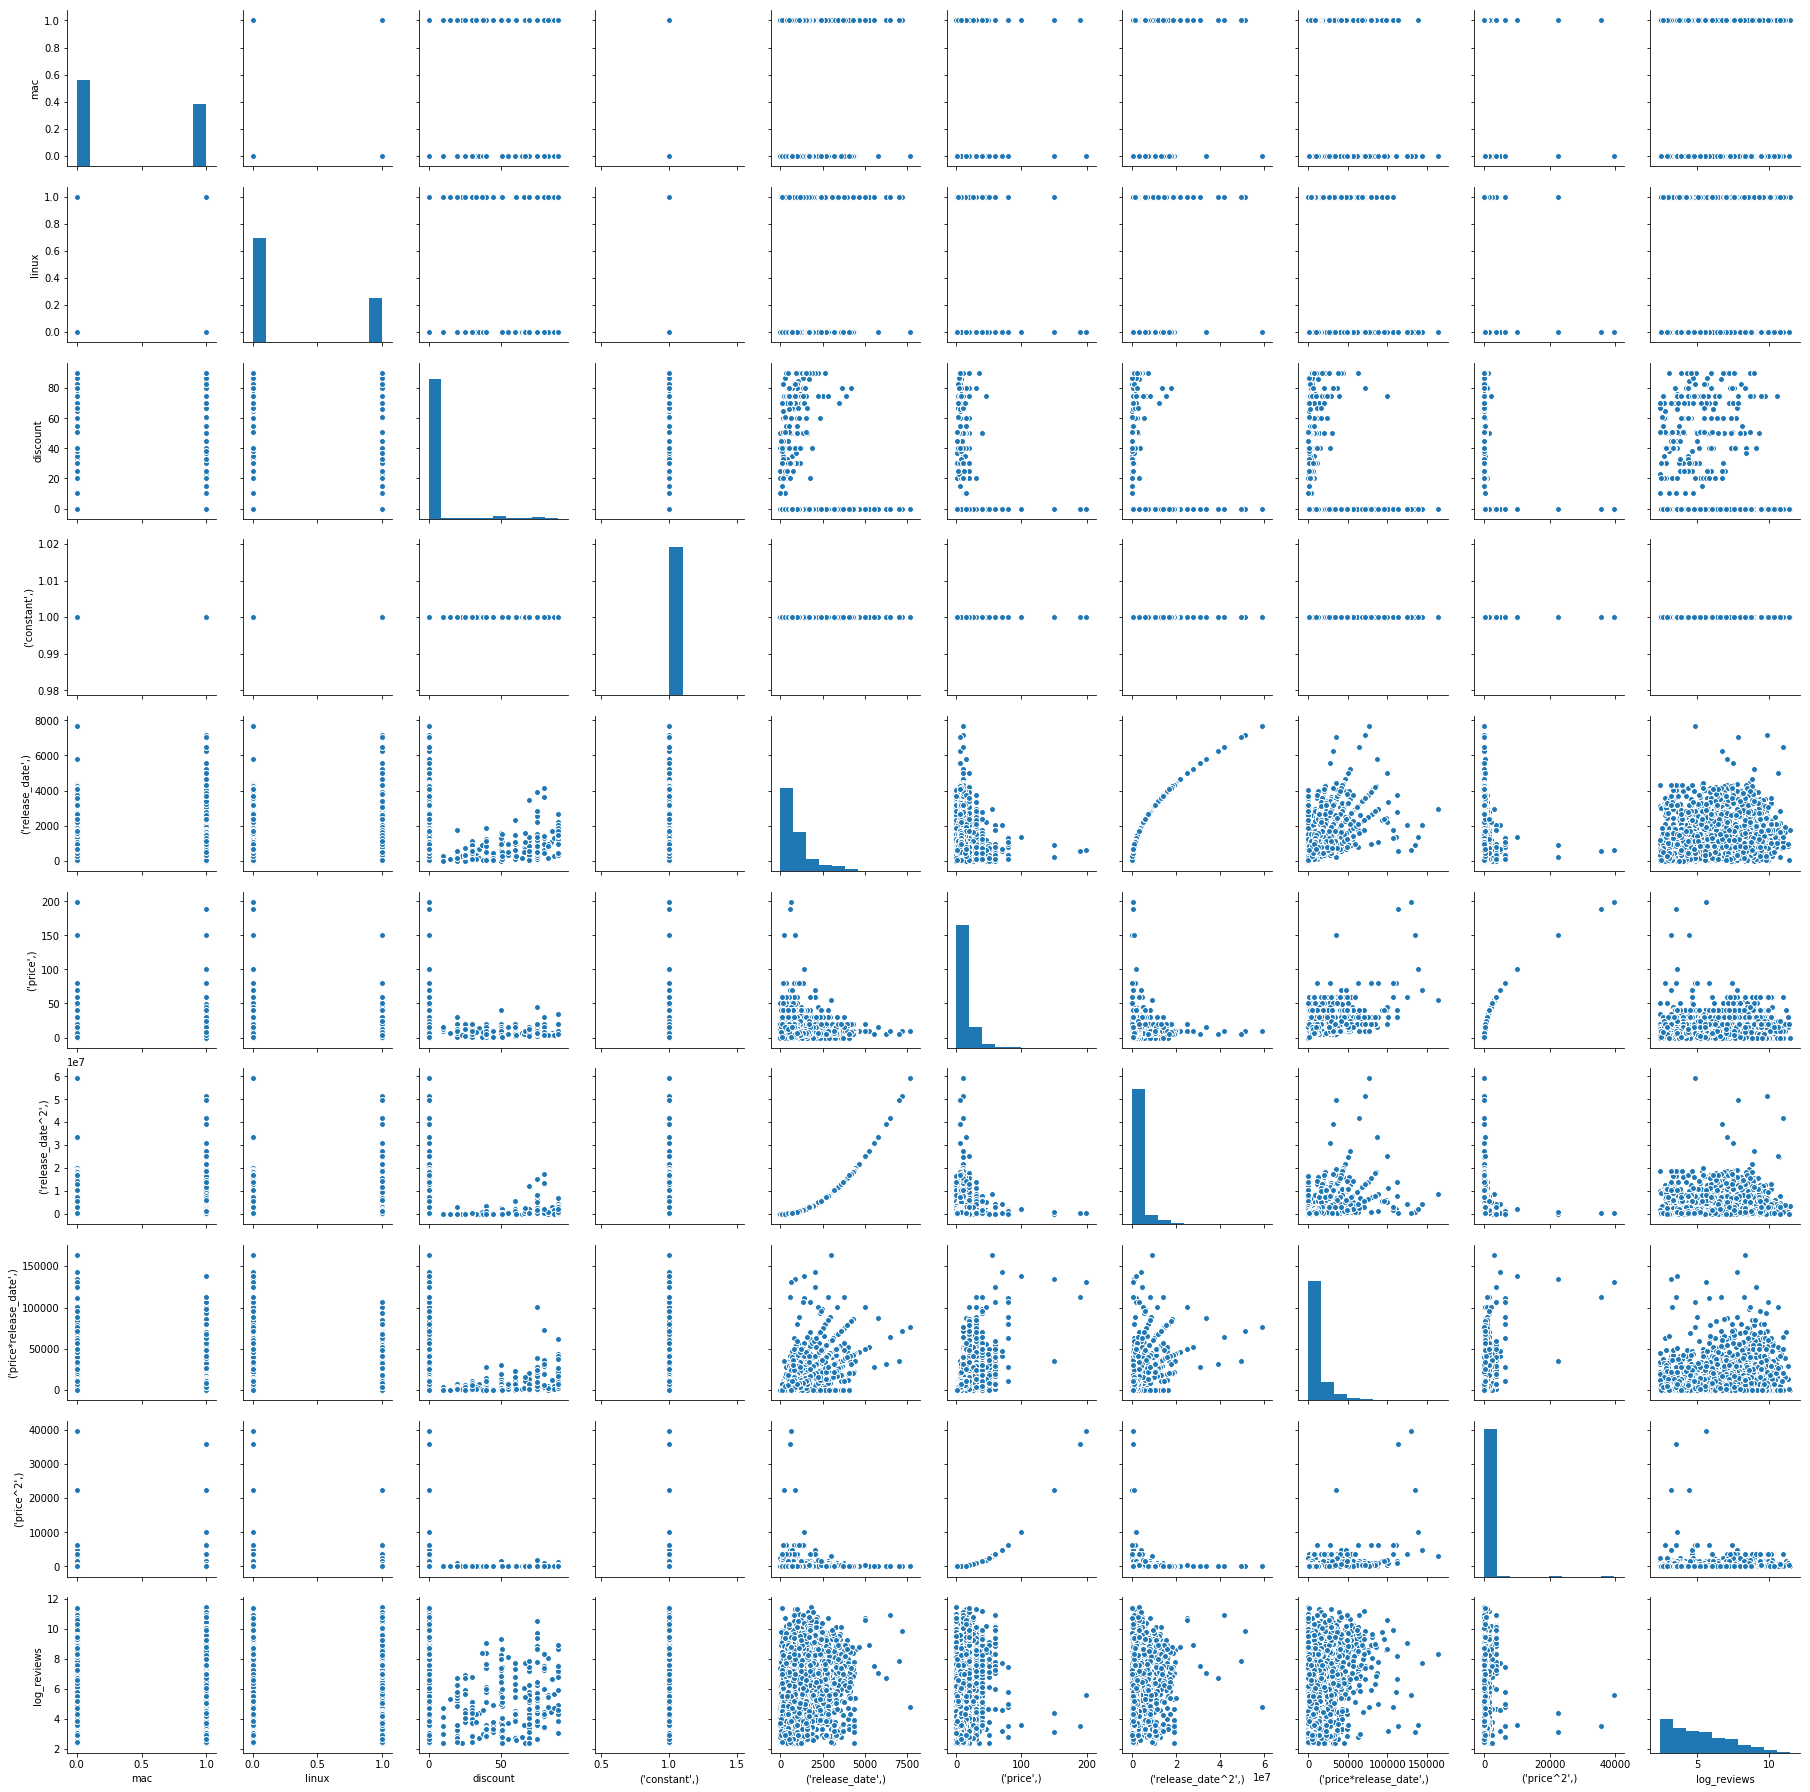

In [35]:
sns.pairplot(polydf_train)

## Correlation Matrix

In [36]:
polydf_train.corr()

,mac,linux,discount,"(constant,)","(release_date,)","(price,)","(release_date^2,)","(price*release_date,)","(price^2,)",log_reviews
mac,1.000000,0.663948,-0.002494,NaN,0.036652,-0.025594,-0.012474,0.010608,-0.022413,0.131847
linux,0.663948,1.000000,-0.005862,NaN,0.003272,-0.023806,-0.032623,-0.016981,-0.026374,0.116551
discount,-0.002494,-0.005862,1.000000,NaN,-0.024713,-0.054925,-0.026007,-0.027371,-0.027149,0.000685
"(constant,)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(release_date,)",0.036652,0.003272,-0.024713,NaN,1.000000,0.009770,0.919075,0.647778,-0.024921,0.363619
"(price,)",-0.025594,-0.023806,-0.054925,NaN,0.009770,1.000000,-0.001918,0.577372,0.767441,0.264791
"(release_date^2,)",-0.012474,-0.032623,-0.026007,NaN,0.919075,-0.001918,1.000000,0.572409,-0.026298,0.272582
"(price*release_date,)",0.010608,-0.016981,-0.027371,NaN,0.647778,0.577372,0.572409,1.000000,0.393664,0.414448
"(price^2,)",-0.022413,-0.026374,-0.027149,NaN,-0.024921,0.767441,-0.026298,0.393664,1.000000,0.097459
log_reviews,0.131847,0.116551,0.000685,NaN,0.363619,0.264791,0.272582,0.414448,0.097459,1.000000


# 12. Regression with Polynomial Features on Log Values

## OLS Model

In [37]:
y2_train_poly = polydf_train['log_reviews']

model3 = sm.OLS(y2_train_poly, sm.add_constant(polydf_x))
fit3 = model3.fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_reviews   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     176.2
Date:                Thu, 19 Jul 2018   Prob (F-statistic):          9.52e-256
Time:                        18:00:48   Log-Likelihood:                -8000.6
No. Observations:                4034   AIC:                         1.602e+04
Df Residuals:                    4025   BIC:                         1.608e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
mac                         0.2789      0.075      3.698      0.000       0.131       0.427
linux                       0.2857      0.081      3.522      0.000       0.127       0.445
discount                    0.0037      0.002      1.850      0.064      -0.000       0.008
('constant',)               3.2452      0.071     45.693      0.000       3.106       3.384
('release_date',)           0.0013   8.74e-05     15.198      0.000       0.001       0.001
('price',)                  0.0696      0.005     14.419      0.000       0.060       0.079
('release_date^2',)     -1.801e-07   1.91e-08     -9.438      0.000   -2.17e-07   -1.43e-07
('price*release_date',)  9.498e-06   3.71e-06      2.560      0.010    2.22e-06    1.68e-05
('price^2',)               -0.0004   3.93e-05    -10.335      0.000      -0.000      -0.000
==============================================================================
Omnibus:                      186.439   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.855
Skew:                           0.553   Prob(JB):                     9.92e-47
Kurtosis:                       3.198   Cond. No.                     1.51e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## K-Fold CV

### 10-fold Cross Validation Split

In [38]:
kf3=KFold(n=len(polydf_x), n_folds=10, shuffle=True, random_state=20)

### Calculate Avg Score Across Folds

In [39]:
score(kf3,polydf_x,y2_train_poly)

('train score mean: 0.25959849680583397',
 'test score mean: 0.25337441600319993')

## Plot Predicted vs Actual

Text(0.5,1,'Actual vs Predicted')

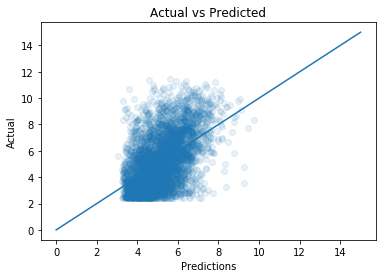

In [40]:
predict3 = fit3.predict(sm.add_constant(polydf_x))
plt.scatter(predict3,y2_train_poly,alpha=.1)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.plot(np.linspace(0,15,100),np.linspace(0,15,100))
plt.title('Actual vs Predicted')

## Diagnostic Plots

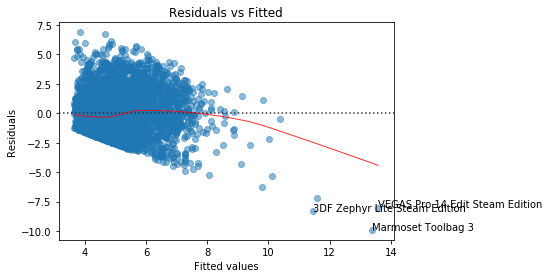

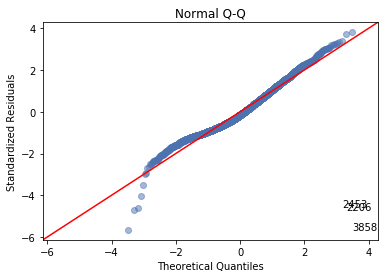

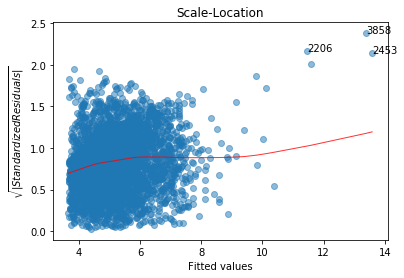

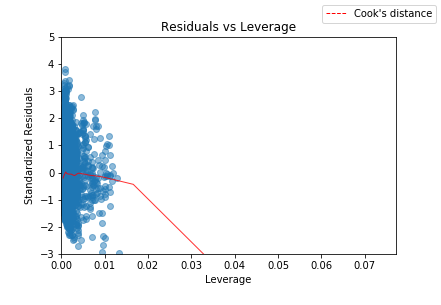

In [41]:
diagnostic_plots.diagnostic_plots(polydf_x, y2_train_poly, fit2)

# 13. Compare Different Models

## Function to Compare Each Model's Mean R2 Within Folds

In [42]:
def get_scores(X, y, kf, alpha = 0.5): 

    models = {}
    parameters = {}
    
    models['linear_model'] = linear_model.LinearRegression()
    models['ridge_model'] = linear_model.Ridge()
    models['lasso_model'] = linear_model.Lasso(alpha=alpha)
    models['lasso_cv_model'] = linear_model.LassoCV()
    models['robust_regression'] = linear_model.SGDRegressor(loss='huber',max_iter=2000)
    models['eps_insensitive'] = linear_model.SGDRegressor(loss='epsilon_insensitive',max_iter=2000)
    models['cart'] = tree.DecisionTreeRegressor(max_depth=7)
    models['extratrees'] = tree.ExtraTreeRegressor(max_depth=7)
    models['randomForest'] = ensemble.RandomForestRegressor()
    models['adaboostedTrees'] = ensemble.AdaBoostRegressor()
    models['gradboostedTrees'] = ensemble.GradientBoostingRegressor()
     
    overall_scores_train=[]
    overall_scores_test=[]
    for name,model in models.items():
        scores_train=[]
        scores_test=[]
        for train, test in kf:
            Xt_train = X.iloc[train]
            yt_train=y.iloc[train]
            X_val = X.iloc[test]
            y_val = y.iloc[test]

            model.fit(Xt_train, yt_train)
            
            scores_train.append(model.score(Xt_train,yt_train))
            scores_test.append(model.score(X_val,y_val))

        overall_scores_train.append(np.mean(scores_train))
        overall_scores_test.append(np.mean(scores_test))
    
    scores_df = pd.DataFrame({'Model': list(models.keys()),
                             'Train Scores': overall_scores_train, 'Test Scores': overall_scores_test})

    return scores_df

### Compare with Unlogged Data

In [43]:
get_scores(X_train,y_train, kf)

,Model,Train Scores,Test Scores
0,linear_model,0.067162,0.063766
1,ridge_model,0.067140,0.063788
2,lasso_model,0.067119,0.063793
3,lasso_cv_model,0.060347,0.058522
4,robust_regression,-0.034464,-0.036016
5,eps_insensitive,-0.017228,-0.022294
6,cart,0.475340,-0.234259
7,extratrees,0.238959,-0.005576
8,randomForest,0.793476,-0.163870
9,adaboostedTrees,-0.478345,-0.948030


### Compare with Logged/Modified Data

In [44]:
get_scores(X2_train, y2_train, kf2)

,Model,Train Scores,Test Scores
0,linear_model,0.219625,0.214994
1,ridge_model,0.219625,0.214996
2,lasso_model,0.200394,0.196852
3,lasso_cv_model,0.199791,0.196580
4,robust_regression,-464.987278,-477.574388
5,eps_insensitive,-17333.616827,-17970.544078
6,cart,0.453183,0.294399
7,extratrees,0.310441,0.250959
8,randomForest,0.846362,0.192133
9,adaboostedTrees,0.292569,0.273766


### Compare using Polynomial Features

In [45]:
get_scores(polydf_x, y2_train_poly, kf3)

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.086576e-17
  overwrite_a=True).T
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.964950e-17
  overwrite_a=True).T
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.948329e-17
  overwrite_a=True).T
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal

,Model,Train Scores,Test Scores
0,linear_model,2.595985e-01,2.533744e-01
1,ridge_model,2.595985e-01,2.533759e-01
2,lasso_model,2.431916e-01,2.376059e-01
3,lasso_cv_model,1.668861e-01,1.634777e-01
4,robust_regression,-2.481272e+17,-2.385130e+17
5,eps_insensitive,-3.038718e+18,-2.308815e+18
6,cart,4.519988e-01,2.886572e-01
7,extratrees,3.723984e-01,3.000536e-01
8,randomForest,8.470053e-01,2.025987e-01
9,adaboostedTrees,2.941474e-01,2.762222e-01


## Result: Gradient Boosted Trees is "Best" Model

# 14. Play with Model to Determine "Best" Input Values and Run on Entire Training Data
Best Input in Terms of Mean Score on Test Data Folds

In [46]:
gb = ensemble.GradientBoostingRegressor(alpha=0.9, n_estimators=200, min_samples_split=2, max_depth=3)
cross_val_score(gb, X2_train, y2_train, cv = 10, n_jobs=1, scoring="r2").mean()

0.3757993078995663

# 15. Run Gradient Boosted Trees on Holdout Set- Get Scores

In [53]:
testdf=X_test.join(y_test)
testdf['log_reviews'] = np.log(testdf.reviews + 1)

y2_test = testdf['log_reviews']
X2_test = testdf.drop(['log_reviews','reviews', 'system', 'windows'], axis = 1)

gb.fit(X2_train, y2_train)
print(gb.score(X2_train, y2_train))
print(gb.score(X2_test, y2_test))

#High bias and high variance

0.4818365496905238
0.20635922007282848


# 16. Plot Final Results

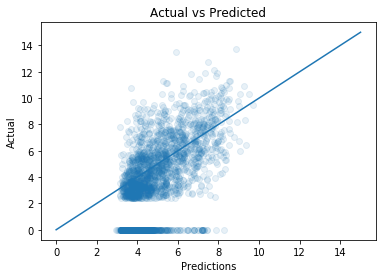

In [48]:
predictions = gb.predict(X2_test)
plt.scatter(predictions,y2_test,alpha=.1)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.plot(np.linspace(0,15,1000),np.linspace(0,15,1000));
plt.title('Actual vs Predicted');